In [67]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

In [2]:
flood_policies = pd.read_csv("nfip-flood-policies.csv", header=0, low_memory = False, memory_map = True)
# https://www.kaggle.com/datasets/lynma01/femas-national-flood-insurance-policy-database
flood_policies.head()

,agriculturestructureindicator,basefloodelevation,basementenclosurecrawlspacetype,cancellationdateoffloodpolicy,censustract,condominiumindicator,construction,countycode,crsdiscount,deductibleamountinbuildingcoverage,...,primaryresidenceindicator,propertystate,reportedzipcode,ratemethod,regularemergencyprogramindicator,reportedcity,smallbusinessindicatorbuilding,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,totalinsurancepremiumofthepolicy
0,NaN,NaN,2.0,NaN,3.301304e+10,N,N,33013.0,0.00,0,...,Y,NH,03278,7,R,WARNER,NaN,250000.0,100000.0,375.0
1,NaN,NaN,0.0,NaN,2.206304e+10,N,N,22063.0,0.05,1,...,Y,LA,70726,1,R,DENHAM SPRINGS,NaN,16400.0,8800.0,280.0
2,NaN,NaN,0.0,NaN,4.505106e+10,N,N,45051.0,0.00,0,...,Y,SC,29579,7,R,MYRTLE BEACH,NaN,250000.0,100000.0,335.0
3,NaN,519.0,2.0,2016-04-01,1.055001e+09,N,N,1055.0,0.00,1,...,Y,AL,35901,2,R,GADSDEN,NaN,174900.0,21000.0,916.0
4,NaN,7.0,0.0,NaN,1.208600e+10,N,N,12086.0,0.00,0,...,Y,FL,33160,1,R,GOLDEN BEACH,NaN,250000.0,100000.0,1288.0


In [45]:
original_columns = [
    'agriculturestructureindicator', 'basefloodelevation', 'basementenclosurecrawlspacetype',
    'cancellationdateoffloodpolicy', 'censustract', 'condominiumindicator',
    'construction', 'countycode', 'crsdiscount', 'deductibleamountinbuildingcoverage',
    'deductibleamountincontentscoverage', 'elevatedbuildingindicator',
    'elevationcertificateindicator', 'elevationdifference', 'federalpolicyfee',
    'floodzone', 'hfiaasurcharge', 'houseofworshipindicator', 'latitude',
    'locationofcontents', 'longitude', 'lowestadjacentgrade', 'lowestfloorelevation',
    'nonprofitindicator', 'numberoffloorsininsuredbuilding', 'obstructiontype',
    'occupancytype', 'originalconstructiondate', 'originalnbdate', 'policycost',
    'policycount', 'policyeffectivedate', 'policyterminationdate',
    'policytermindicator', 'postfirmconstructionindicator', 'primaryresidenceindicator',
    'propertystate', 'reportedzipcode', 'ratemethod', 'regularemergencyprogramindicator',
    'reportedcity', 'smallbusinessindicatorbuilding', 'totalbuildinginsurancecoverage',
    'totalcontentsinsurancecoverage', 'totalinsurancepremiumofthepolicy'
]
# --- The Hard-Code'd Rename Dictionary ---
# This dictionary explicitly maps each old name (key) to a new name (value).
column_rename_map = {
    'agriculturestructureindicator': 'agriculture_structure_indicator',
    'basefloodelevation': 'base_flood_elevation',
    'basementenclosurecrawlspacetype': 'basement_enclosure_crawlspace_type',
    'cancellationdateoffloodpolicy': 'cancellation_date_of_flood_policy',
    'censustract': 'census_tract',
    'condominiumindicator': 'condominium_indicator',
    'construction': 'construction',
    'countycode': 'county_code',
    'crsdiscount': 'crs_discount',
    'deductibleamountinbuildingcoverage': 'deductible_amount_in_building_coverage',
    'deductibleamountincontentscoverage': 'deductible_amount_in_contents_coverage',
    'elevatedbuildingindicator': 'elevated_building_indicator',
    'elevationcertificateindicator': 'elevation_certificate_indicator',
    'elevationdifference': 'elevation_difference',
    'federalpolicyfee': 'federal_policy_fee',
    'floodzone': 'flood_zone',
    'hfiaasurcharge': 'hfiaa_surcharge',
    'houseofworshipindicator': 'house_of_worship_indicator',
    'latitude': 'latitude',
    'locationofcontents': 'location_of_contents',
    'longitude': 'longitude',
    'lowestadjacentgrade': 'lowest_adjacent_grade',
    'lowestfloorelevation': 'lowest_floor_elevation',
    'nonprofitindicator': 'non_profit_indicator',
    'numberoffloorsininsuredbuilding': 'number_of_floors_in_insured_building',
    'obstructiontype': 'obstruction_type',
    'occupancytype': 'occupancy_type',
    'originalconstructiondate': 'original_construction_date',
    'originalnbdate': 'original_nb_date',
    'policycost': 'policy_cost',
    'policycount': 'policy_count',
    'policyeffectivedate': 'policy_effective_date',
    'policyterminationdate': 'policy_termination_date',
    'policytermindicator': 'policy_term_indicator',
    'postfirmconstructionindicator': 'post_firm_construction_indicator',
    'primaryresidenceindicator': 'primary_residence_indicator',
    'propertystate': 'property_state',
    'reportedzipcode': 'reported_zipcode',
    'ratemethod': 'rate_method',
    'regularemergencyprogramindicator': 'regular_emergency_program_indicator',
    'reportedcity': 'reported_city',
    'smallbusinessindicatorbuilding': 'small_business_indicator_building',
    'totalbuildinginsurancecoverage': 'total_building_insurance_coverage',
    'totalcontentsinsurancecoverage': 'total_contents_insurance_coverage',
    'totalinsurancepremiumofthepolicy': 'total_insurance_premium_of_the_policy'
}

# --- Apply the renaming ---
# The .rename() method creates a new DataFrame with the new column names.
# We assign it back to 'df'.
df = flood_policies.rename(columns=column_rename_map)

In [46]:
df.isna().sum()

agriculture_structure_indicator           38923313
base_flood_elevation                      33636760
basement_enclosure_crawlspace_type             803
cancellation_date_of_flood_policy         43614058
census_tract                                467120
condominium_indicator                            7
construction                                    14
county_code                                  49000
crs_discount                                     1
deductible_amount_in_building_coverage      661994
deductible_amount_in_contents_coverage     5561585
elevated_building_indicator                    259
elevation_certificate_indicator           32606398
elevation_difference                             1
federal_policy_fee                               1
flood_zone                                  169146
hfiaa_surcharge                                  1
house_of_worship_indicator                34476252
latitude                                    338700
location_of_contents           

In [47]:
total_coverage = df['total_building_insurance_coverage']+df['total_contents_insurance_coverage']
premium = df['total_insurance_premium_of_the_policy']
df['premium_rate'] = np.where(total_coverage == 0,
                              np.nan,
                              premium / total_coverage)

In [48]:
df_subset = df[['flood_zone', 'latitude', 'longitude', 'property_state', 'reported_zipcode', 'reported_city',
         'small_business_indicator_building', 'obstruction_type',
         'non_profit_indicator', 'house_of_worship_indicator', 'agriculture_structure_indicator',
         'cancellation_date_of_flood_policy', 'original_nb_date', 'policy_effective_date', 'policy_termination_date',
         'total_building_insurance_coverage', 'total_contents_insurance_coverage', 'total_insurance_premium_of_the_policy', 'premium_rate']]


In [49]:
mask = df_subset[['small_business_indicator_building', 'obstruction_type', 
                  'non_profit_indicator', 'house_of_worship_indicator', 'agriculture_structure_indicator',
                  'cancellation_date_of_flood_policy']].isna()

In [50]:
df_subset[mask] = "Unknown"

C:\Users\Hobbs\AppData\Local\Temp\ipykernel_3012\934070242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[mask] = "Unknown"
C:\Users\Hobbs\AppData\Local\Temp\ipykernel_3012\934070242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[mask] = "Unknown"


In [51]:
df_subset.isna().sum()

flood_zone                               169146
latitude                                 338700
longitude                                338700
property_state                                1
reported_zipcode                              8
reported_city                                12
small_business_indicator_building             0
obstruction_type                              0
non_profit_indicator                          0
house_of_worship_indicator                    0
agriculture_structure_indicator               0
cancellation_date_of_flood_policy             0
original_nb_date                              1
policy_effective_date                         1
policy_termination_date                       1
total_building_insurance_coverage             1
total_contents_insurance_coverage             1
total_insurance_premium_of_the_policy         1
premium_rate                                 75
dtype: int64

In [52]:
df_subset = df_subset.dropna()

In [59]:
df_subset['cancellation_date_of_flood_policy'] = pd.to_datetime(df_subset['cancellation_date_of_flood_policy'], errors='coerce')
df_subset['original_nb_date'] = pd.to_datetime(df_subset['original_nb_date'])
df_subset['policy_effective_date'] = pd.to_datetime(df_subset['policy_effective_date'])
df_subset['policy_termination_date'] = pd.to_datetime(df_subset['policy_termination_date'])
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49901266 entries, 0 to 50406942
Data columns (total 19 columns):
 #   Column                                 Dtype         
---  ------                                 -----         
 0   flood_zone                             object        
 1   latitude                               float64       
 2   longitude                              float64       
 3   property_state                         object        
 4   reported_zipcode                       object        
 5   reported_city                          object        
 6   small_business_indicator_building      object        
 7   obstruction_type                       object        
 8   non_profit_indicator                   object        
 9   house_of_worship_indicator             object        
 10  agriculture_structure_indicator        object        
 11  cancellation_date_of_flood_policy      datetime64[ns]
 12  original_nb_date                       datetime64[ns]
 13  

In [ ]:
img = Image.open('flood_zones.avif')
display(img)

In [60]:
mask = df_subset['flood_zone'].str.contains('^A')
df_subset['high_flood_zone'] = False
df_subset.loc[mask, 'high_flood_zone'] = True
mask = df_subset['flood_zone'].str.contains('^V')
df_subset['coastal_high_flood_zone'] = False
df_subset.loc[mask, 'coastal_high_flood_zone'] = True
mask = df_subset['flood_zone'].str.contains('^[BCX]')
df_subset['low_moderate_flood_zone'] = False
df_subset.loc[mask, 'low_moderate_flood_zone'] = True
mask = df_subset['flood_zone'].str.contains('^D')
df_subset['undetermined_flood_zone'] = False
df_subset.loc[mask, 'undetermined_flood_zone'] = True
df_subset.head()

,flood_zone,latitude,longitude,property_state,reported_zipcode,reported_city,small_business_indicator_building,obstruction_type,non_profit_indicator,house_of_worship_indicator,...,policy_effective_date,policy_termination_date,total_building_insurance_coverage,total_contents_insurance_coverage,total_insurance_premium_of_the_policy,premium_rate,high_flood_zone,coastal_high_flood_zone,low_moderate_flood_zone,undetermined_flood_zone
0,X,43.3,-71.8,NH,03278,WARNER,Unknown,Unknown,Unknown,Unknown,...,2009-08-19,2010-08-19,250000.0,100000.0,375.0,0.001071,False,False,True,False
1,AE,30.5,-91.0,LA,70726,DENHAM SPRINGS,Unknown,Unknown,Unknown,Unknown,...,2009-10-04,2010-10-04,16400.0,8800.0,280.0,0.011111,True,False,False,False
2,X,33.7,-79.0,SC,29579,MYRTLE BEACH,Unknown,Unknown,Unknown,Unknown,...,2009-08-13,2010-08-13,250000.0,100000.0,335.0,0.000957,False,False,True,False
3,AE,34.0,-86.0,AL,35901,GADSDEN,Unknown,50,Unknown,Unknown,...,2009-04-14,2010-04-14,174900.0,21000.0,916.0,0.004676,True,False,False,False
4,A10,26.0,-80.1,FL,33160,GOLDEN BEACH,Unknown,Unknown,Unknown,Unknown,...,2009-04-04,2010-04-04,250000.0,100000.0,1288.0,0.003680,True,False,False,False


In [55]:
state_count = df_subset['property_state'].value_counts()
state_count

property_state
FL    14888245
TX     7117910
LA     5508206
CA     2762517
NJ     2047684
NY     1795374
SC     1771833
NC     1430045
VA     1159233
GA     1024144
MS      791391
PA      712238
MA      545136
MD      518806
WA      484828
AL      479558
IL      460212
OH      420947
AZ      372453
CT      368488
OR      339476
TN      338394
IN      316031
PR      280045
MO      271592
KY      263320
MI      261567
DE      229108
CO      216614
AR      215585
WV      215074
HI      204821
OK      182200
NM      176205
IA      168703
WI      167451
RI      151818
ND      148815
NV      147880
NE      133989
KS      133681
MN      133389
ME       92757
NH       81005
ID       73027
MT       62668
SD       58153
VT       44331
UT       40903
AK       31882
WY       26895
DC       16661
VI       15277
GU        2530
CM         100
AS          71
Name: count, dtype: int64

In [56]:
df_michigan = df_subset[df_subset['property_state'] == 'MI']

In [57]:
df_michigan.head()

,flood_zone,latitude,longitude,property_state,reported_zipcode,reported_city,small_business_indicator_building,obstruction_type,non_profit_indicator,house_of_worship_indicator,agriculture_structure_indicator,cancellation_date_of_flood_policy,original_nb_date,policy_effective_date,policy_termination_date,total_building_insurance_coverage,total_contents_insurance_coverage,total_insurance_premium_of_the_policy,premium_rate
420,C,43.1,-86.2,MI,49456,SPRING LAKE,Unknown,Unknown,Unknown,Unknown,Unknown,NaT,2007-09-06,2009-09-06,2010-09-06,125000.0,50000.0,294.0,0.001680
636,X,42.3,-83.3,MI,48125,DEARBORN HGTS,Unknown,Unknown,Unknown,Unknown,Unknown,NaT,1999-08-18,2009-01-12,2010-01-12,172700.0,0.0,585.0,0.003387
764,C,42.1,-86.4,MI,49085,SAINT JOSEPH,Unknown,10,Unknown,Unknown,Unknown,2010-06-16,1997-06-16,2009-06-16,2010-06-16,150000.0,60000.0,283.0,0.001348
1161,AE,42.8,-86.2,MI,49434,MACATAWA,Unknown,Unknown,Unknown,Unknown,Unknown,NaT,2007-07-20,2009-07-20,2010-07-20,500000.0,0.0,2500.0,0.005000
1349,AE,42.3,-83.8,MI,48103,ANN ARBOR,Unknown,Unknown,Unknown,Unknown,Unknown,NaT,2008-04-08,2009-04-08,2010-04-08,70000.0,0.0,638.0,0.009114


Text(0.5, 1.0, 'Count of Properties in Each Flood Zone')

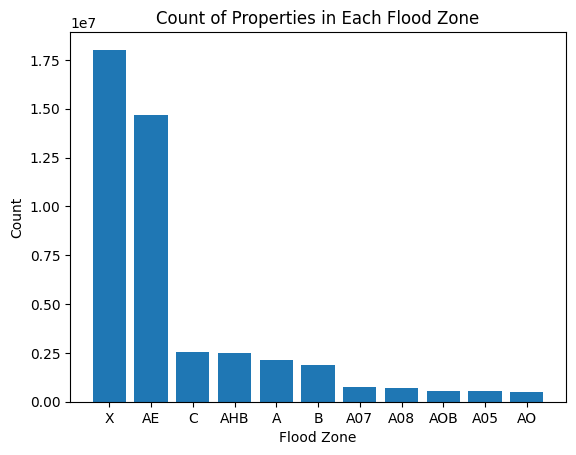

In [ ]:
floodzone_counts = df_subset['flood_zone'].value_counts()

labels = floodzone_counts[:11].index
heights = floodzone_counts[:11].values

plt.bar(labels, heights)
plt.xlabel("Flood Zone")
plt.ylabel("Count")
plt.title("Count of Properties in Each Flood Zone US")

Text(0.5, 1.0, 'Count of Properties in Each Flood Zone Level US')

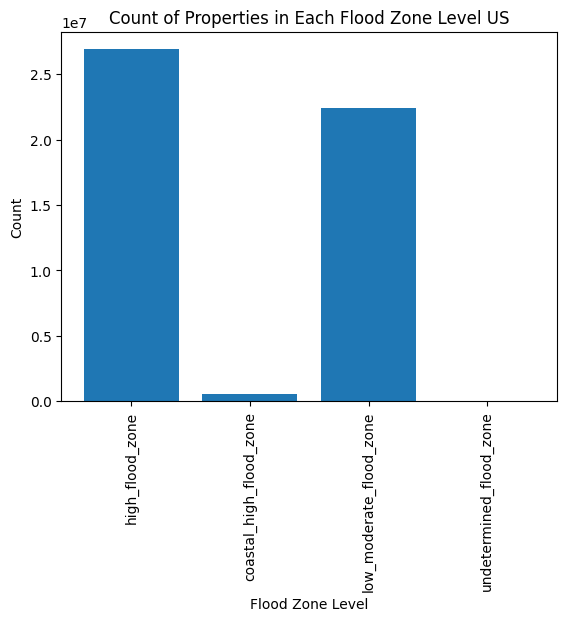

In [71]:
floodzone_counts = df_subset[["high_flood_zone","coastal_high_flood_zone","low_moderate_flood_zone","undetermined_flood_zone"]].sum()
labels = floodzone_counts.index
heights = floodzone_counts.values
plt.bar(labels, heights)
plt.xticks(rotation = 90)
plt.xlabel("Flood Zone Level")
plt.ylabel("Count")
plt.title("Count of Properties in Each Flood Zone Level US")

Text(0.5, 1.0, 'Count of Properties in Each Flood Zone')

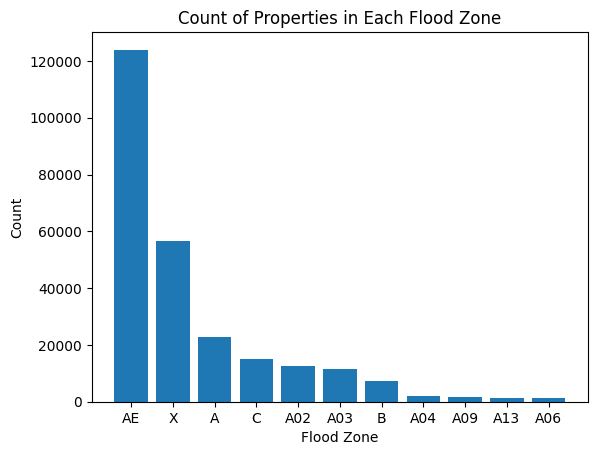

In [ ]:
floodzone_counts = df_michigan['flood_zone'].value_counts()

labels = floodzone_counts[:11].index
heights = floodzone_counts[:11].values

plt.bar(labels, heights)
plt.xlabel("Flood Zone")
plt.ylabel("Count")
plt.title("Count of Properties in Each Flood Zone MI")

([0, 1, 2, 3],
 [Text(0, 0, 'High_floodzone'),
  Text(1, 0, 'Coastal_High_floodzone'),
  Text(2, 0, 'Low_Moderate_floodzone'),
  Text(3, 0, 'Undetermined_floodzone')])

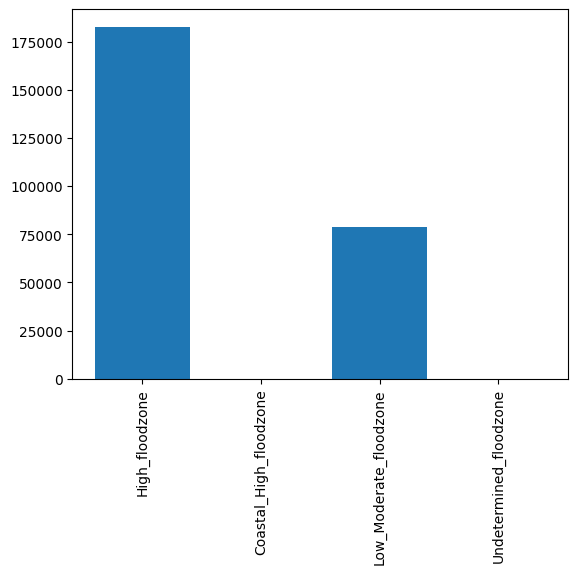

In [ ]:
floodzone_counts = df_michigan[["high_flood_zone","coastal_high_flood_zone","low_moderate_flood_zone","undetermined_flood_zone"]].sum()
labels = floodzone_counts.index
heights = floodzone_counts.values
plt.bar(labels, heights)
plt.xticks(rotation = 90)
plt.xlabel("Flood Zone Level")
plt.ylabel("Count")
plt.title("Count of Properties in Each Flood Zone Level MI")